In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sb
import math
import tensorflow
import sklearn
import os
import shutil
import warnings
warnings.filterwarnings('ignore')
import kagglehub

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from statsmodels.tsa.api import adfuller, ARIMA, Holt, SimpleExpSmoothing, ExponentialSmoothing, ETSModel, seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import arch
from arch import arch_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, "data")
os.makedirs(data_dir, exist_ok=True)

destination_train_file = os.path.join(data_dir, "DailyDelhiClimateTrain.csv")
destination_test_file = os.path.join(data_dir, "DailyDelhiClimateTest.csv")

#download only if not available 
if not (os.path.exists(destination_train_file) and os.path.exists(destination_test_file)):
    print("Downloading dataset from Kagglehub.")
    try:
        downloaded_data_path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")
        print("Path to dataset files:", downloaded_data_path)
        if downloaded_data_path is None:
            raise FileNotFoundError("Downloaded data path is empty, no dataset found.")
        else:
            source_train_file = os.path.join(downloaded_data_path, "DailyDelhiClimateTrain.csv")
            source_test_file = os.path.join(downloaded_data_path, "DailyDelhiClimateTest.csv")
            shutil.copy(source_train_file, destination_train_file)
            shutil.copy(source_test_file, destination_test_file)
            print("Dataset downloaded to the data folder.")
    except Exception as e: 
        raise f"Error while downloading data:{e}"
else:
    print("Using existing dataset.")

train_data = pd.read_csv('data/DailyDelhiClimateTrain.csv')
test_data = pd.read_csv('data/DailyDelhiClimateTest.csv')

Using existing dataset.


In [ ]:
#Format train and test data
train_data['date']=pd.to_datetime(train_data['date'], format='%Y-%m-%d')
train_data.set_index('date', inplace=True)

test_data['date']=pd.to_datetime(test_data['date'], format='%Y-%m-%d')
test_data.set_index('date', inplace=True)

#copy for lstm modelling
lstm_train_data = train_data.copy()
lstm_test_data = test_data.copy()


<Axes: xlabel='date'>

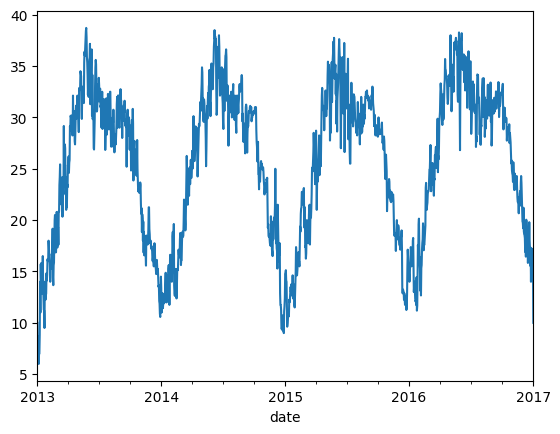

In [ ]:
train_data['meantemp'].plot()
# This suggests a slow upward trend (though it’s not huge, it’s visible).
#strong yearly seasonality: The yearly cycle is very clear - High temps around mid-year (summer). Low temps around year-end (winter).

In [ ]:
def stationarity_check(data):
    result = adfuller(data)
    if result[1]<0.05:
        print("Data is stationary.")
        plot_acf(data, lags=40, title='ACF plot for target')
        mp.show()
        plot_pacf(data, lags=40, title='PACF plot for target')
        mp.show()
    else:
        print("Data is not stationary.")
        plot_acf(data, lags=40, title='ACF plot for target')
        mp.show()
        plot_pacf(data, lags=40, title='PACF plot for target')
        mp.show()

Data is not stationary.


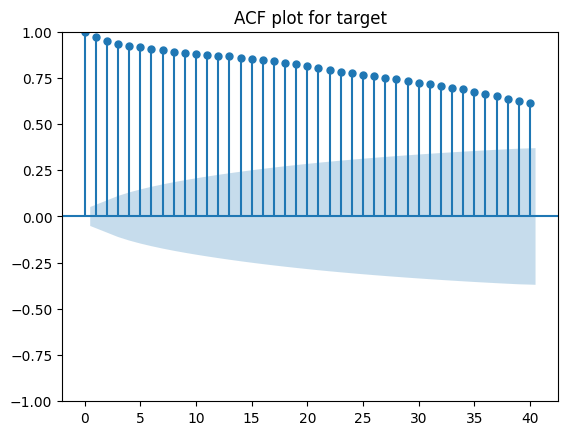

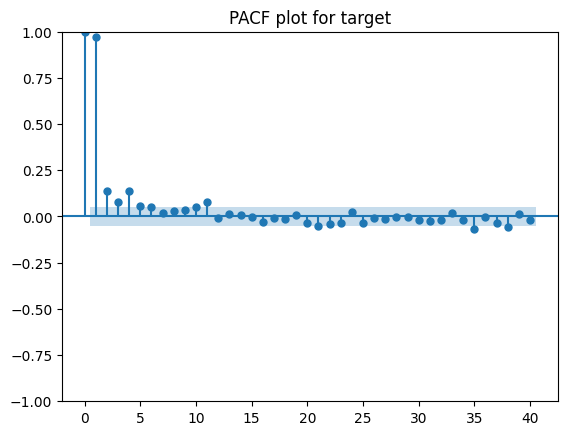

In [ ]:
stationarity_check(train_data['meantemp'])

Seasonal decompose for meantemp


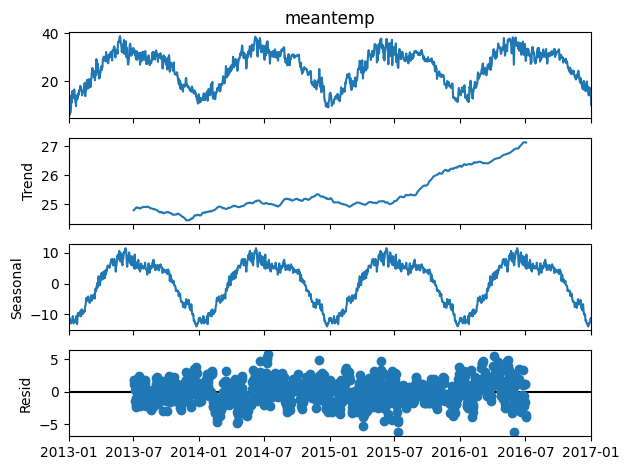

In [ ]:
#this is daily data hence yearly seasonality is 365 else 12
sd = seasonal_decompose(train_data['meantemp'], model='additive', period=365)
print("Seasonal decompose for meantemp")
sd.plot()
mp.show()

In [ ]:
# First seasonal differencing (remove yearly cycles)
train_data['temp_seasonal_diff']=train_data['meantemp'].diff(365)
train_data=train_data.dropna()

#Then first differencing (remove remaining trend)
train_data['temp_st']=train_data['temp_seasonal_diff'].diff()   #remove trend
train_data=train_data.dropna()

Data is stationary.


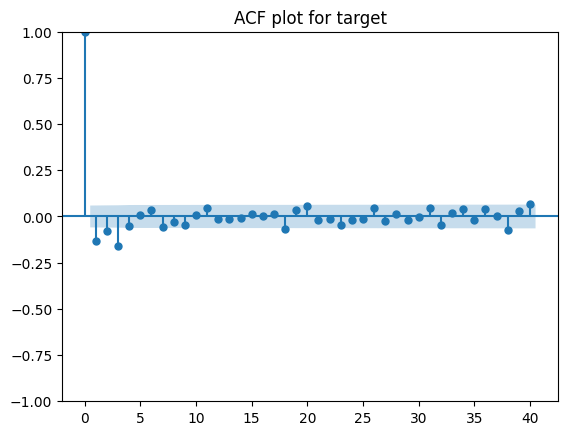

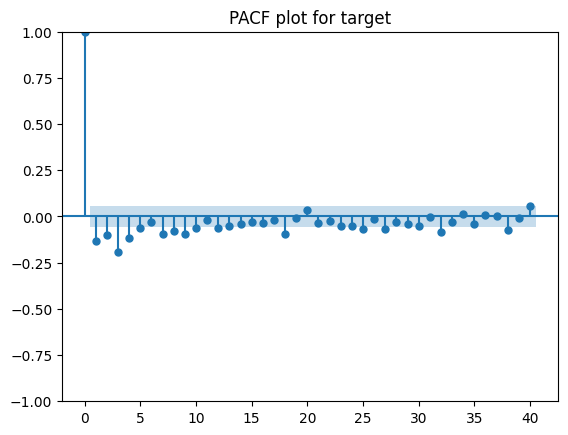

In [ ]:
stationarity_check(train_data['temp_st'])

In [ ]:
# from pmdarima import auto_arima

# model = auto_arima(train_data['meantemp'],
#                    seasonal=True,
#                    m=365,
#                    max_p=2, max_q=2,
#                    d=0, D=1,
#                    trace=True,
#                    stepwise=True)


SARIMA MODEL WITH YEARLY SEASONALITY

Error metrics:
MAE:21.66207197670044, MAPE:99.7%


<Axes: xlabel='date'>

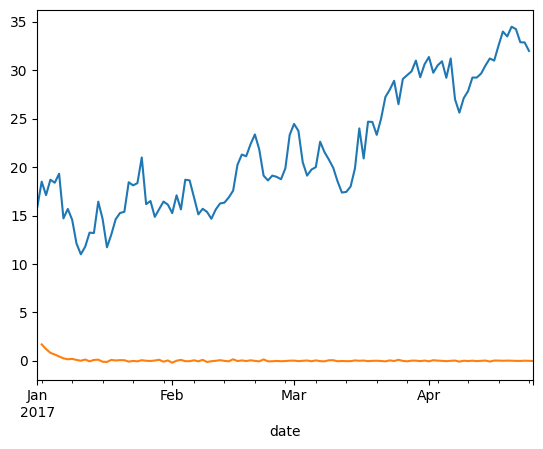

In [ ]:
sarimax_model = SARIMAX(train_data['temp_st'], order=(1,0,1), seasonal_order=(1,0,1,365))
sarimax_model = sarimax_model.fit()
start = len(train_data)
end = len(train_data)+len(test_data)-1
sarimax_predictions = sarimax_model.predict(start, end)
sarimax_mae = mean_absolute_error(test_data['meantemp'], sarimax_predictions)
sarimax_mape = round(mean_absolute_percentage_error(test_data['meantemp'], sarimax_predictions)*100,2)

print("Error metrics:")
print(f"MAE:{sarimax_mae}, MAPE:{sarimax_mape}%")
test_data['meantemp'].plot()
sarimax_predictions.plot()

In [ ]:
# arch, garch
#LSTM model
# monte carlo

LSTM MODEL

In [ ]:
#split the features, target
lstm_train_features_only = lstm_train_data.drop(columns=['meantemp'])
lstm_train_target_only = lstm_train_data['meantemp']

lstm_test_features_only = lstm_test_data.drop(columns=['meantemp'])
lstm_test_target_only = lstm_test_data['meantemp']

#define sequence length, batch size
sequence_length=30
batch_size=1
n_features = lstm_train_features_only.shape[1]

#timeseriesgenerator for generating train and test sequences
train_sequences = TimeseriesGenerator(lstm_train_features_only, lstm_train_target_only, length=sequence_length, batch_size=batch_size)
test_sequences = TimeseriesGenerator(lstm_test_features_only, lstm_test_target_only, length=sequence_length, batch_size=batch_size)

#build a sequential model 
model = Sequential()  
model.add(LSTM(units=60, activation='relu', input_shape=(sequence_length, n_features), return_sequences=True))  #input layer
model.add(LSTM(units=20, activation='relu'))
model.add(Dense(units=1)) #output layer

#compile
model.compile(optimizer='adam', loss='mae')

#train the data
model.fit(x=train_sequences, batch_size=batch_size, epochs=40, callbacks=EarlyStopping(monitor='loss', patience=15, mode='max'))

#make predictions
lstm_predictions = pd.DataFrame(model.predict(test_sequences))

Epoch 1/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 662.3501
Epoch 2/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 18.9420
Epoch 3/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 8.4171
Epoch 4/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 6.7439
Epoch 5/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 6.8143
Epoch 6/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 7.5710
Epoch 7/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 6.7349
Epoch 8/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 6.4170
Epoch 9/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 6.5449
Epoch 10/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 7.9832
Epoch 11/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 6.9259
Epoch 12/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 6.1904
Epoch 13/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 6.1460
Epoch 14/40
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 5.9252
Epoch 15/

In [ ]:
#compare the actuals vs predicted

features = []
targets = []

for i in range(len(test_sequences)):
    x, y = test_sequences[i]
    # print(x,y)
    features.append(x[0][0])
    targets.append(y[0])
features = pd.DataFrame(features)
targets = pd.DataFrame(targets)

actuals = pd.concat([features, targets], axis=1, ignore_index=True)
actuals.columns = lstm_test_data.columns
lstm_mae = mean_absolute_error(actuals['meantemp'], lstm_predictions)
lstm_mape = round(mean_absolute_percentage_error(actuals['meantemp'], lstm_predictions)*100,2)

print("Error metrics:")
print(f"MAE:{lstm_mae:.2f}, MAPE:{lstm_mape}%")

actuals_vs_predicted = pd.concat([actuals['meantemp'], lstm_predictions], axis=1, ignore_index=True)
actuals_vs_predicted.plot()